In [4]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Oct 2, 2017
# Edited, Michal Segal Rozenhaimer, Oct-13-2017, minor tweaks
# Edited, Michal segal rozenhaimer, Oct-16-2017, only FC model
# Edited, Michal Segal Rozenhaimer, Oct-17-2017, testing FC for image patch size
# Edited, Michal Segal Rozenhaimer, Oct-19-2017, testing CNN for image patch size

import sys
import random
import numpy as np
import cv2
import tensorflow as tf
import glob
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
import pandas as pd
import logging
import keras
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.initializers import RandomNormal, TruncatedNormal
from keras.optimizers import SGD
from keras import losses
from keras import backend as K
from keras.models import model_from_json
from sklearn.metrics import accuracy_score

# Config the matplotlib backend as plotting in line in IPython
%matplotlib notebook

In [5]:
def load_data(Imagepath, Truthpath, truth_key = None):
    # Load images
    img1 = cv2.imread(Imagepath,cv2.IMREAD_UNCHANGED)
    img1_truth = cv2.imread(Truthpath,cv2.IMREAD_UNCHANGED)
    
    # Set labels from 0 to item_counter based upon input truth_key
    # truth_key sets the class labels
    # 16  = 0  # Sand
    # 160 = 1  # Branching
    # 198 = 2  # Mounding
    # 38  = 3  # Rock
    if truth_key is not None:
        item_counter = 0
        for item in truth_key:
            img1_truth[img1_truth == item ] = item_counter  # Sand
            item_counter+=1
    return img1, img1_truth

#### Normalize Image
'''Input:
    dataset: set of vectorized images, N_images x nrow x ncol x n_channels
    depth: pixel depth, float
Output:
    dataset_norm: set of vectorized normalized images, N_images x nrow x ncol x n_channels'''
def rescale(dataset, depth):
    dataset_norm = (dataset.astype(np.float32) - depth/2)/(depth/2)
    return dataset_norm

#### Randomize set of data
'''Input:
    dataset: set of images, N_images x (nrow*ncol) x n_channels
    labels: set of labels, N_images x N_labels x num_labels 
Output:
    shuffled_dataset: set of randomized images, N_images x nrow x ncol x (n_channels-n_toremove)
    shuffled_labels: set of randomized labels, N_images x N_labels
'''
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    #print("labels_shape",labels.shape)
    shuffled_dataset = dataset[permutation,:,:,:]
    shuffled_labels  = labels[permutation,:]
    return shuffled_dataset, shuffled_labels   

#### Generate training data as randomized
def generate_training(WholeImage, TruthImage, image_size=25, N_train=20000, N_valid = 2500, N_test = 2500, 
                      toremove = False, figureson = False):
    num_labels = len(np.unique(TruthImage))
    crop_len = int(np.floor(image_size/2))
    print("TruthImage_shape",TruthImage.shape)
    Truth_crop = TruthImage[crop_len:TruthImage.shape[0]-crop_len, crop_len:TruthImage.shape[1]-crop_len]
    print("Truth_crop_shape",Truth_crop.shape)
    
    # Randomly select points
    train_datasets = []
    train_labels = []
    valid_datasets = []
    valid_labels =[]
    test_datasets = []
    test_labels = []
    
    for k in range(num_labels):
        [i,j] = np.where(Truth_crop == k)
        #print("i: ",i,"j: ",j)
        #print("len i: ",len(i),"len j: ",len(j))
        # Training set
        idx = np.asarray(random.sample(range(len(i)), N_train)).astype(int)
        #print("idx",idx)
        #print("length_idx",len(idx))
        train_datasets.append([WholeImage[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
        train_labels.append([Truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
        #print("train_datasets_length",len(train_datasets))
        #print("train_labels_length",  len(train_labels))
        # Validation set
        idx = np.asarray(random.sample(range(len(i)), N_valid)).astype(int)
        valid_datasets.append([WholeImage[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
        valid_labels.append([Truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
        #print("valid_datasets_shape",valid_datasets.shape)
        #print("valid_labels_shape",  valid_labels.shape)
        # Test set
        idx = np.asarray(random.sample(range(len(i)), N_test)).astype(int)
        test_datasets.append([WholeImage[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
        test_labels.append([Truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
        #print("test_datasets_shape",test_datasets.shape)
        #print("test_labels_shape",  test_labels.shape)
        
    # Some array handling and reshaping
    train_datasets = np.asarray(train_datasets) # train_datasets is in the format of num_labels x N_train x nrows x ncols x n_channels
    train_labels = np.asarray(train_labels) # train_labels is in the format of num_labels x N_train
    valid_datasets = np.asarray(valid_datasets)
    valid_labels = np.asarray(valid_labels) 
    test_datasets = np.asarray(test_datasets) 
    test_labels = np.asarray(test_labels)
    
    #print("before_reshaping:")
    #print("train_datasets_shape",train_datasets.shape)
    #print("train_labels_shape",  train_labels.shape)
    #print("valid_datasets_shape",valid_datasets.shape)
    #print("valid_labels_shape"  ,valid_labels.shape)
    #print("test_datasets_shape" , test_datasets.shape)
    #print("test_labels_shape"   ,test_labels.shape)
    
    train_datasets = train_datasets.reshape(num_labels*N_train, image_size, image_size, WholeImage.shape[-1]) # flatten first 2 dimensions of train_datasets
    train_labels = train_labels.reshape(num_labels*N_train,1) # flatten into vector
    valid_datasets = valid_datasets.reshape(num_labels*N_valid, image_size, image_size, WholeImage.shape[-1]) 
    valid_labels = valid_labels.reshape(num_labels*N_valid,1) 
    test_datasets = test_datasets.reshape(num_labels*N_test, image_size, image_size, WholeImage.shape[-1]) 
    test_labels = test_labels.reshape(num_labels*N_test,1)
    
    #print("after_reshaping:")
    #print("train_datasets_shape",train_datasets.shape)
    #print("train_labels_shape",  train_labels.shape)
    #print("valid_datasets_shape",valid_datasets.shape)
    #print("valid_labels_shape"  ,valid_labels.shape)
    #print("test_datasets_shape" , test_datasets.shape)
    #print("test_labels_shape"   ,test_labels.shape)
    
    if toremove is not None:
        train_datasets = np.delete(train_datasets,toremove,-1) # Remove specific last dimension of array
        valid_datasets = np.delete(valid_datasets,toremove,-1) # Remove specific last dimension of array
        test_datasets = np.delete(test_datasets,toremove,-1) # Remove specific last dimension of y
    
    # Plot sample images of different classes
    if figureson:
        plt.figure()
        for i in range(num_labels):
            plt.axis("off")
            plt.subplot(1, num_labels, i+1)
            plt.imshow(cv2.cvtColor(train_datasets[i*N_train,:,:,0:3], cv2.COLOR_BGR2RGB))
            plt.title(train_labels[i*N_train])
        plt.axis("off")
        plt.show()
        plt_name = "cnn_train_sample_image_size_" + str(image_size) + ".png"
        plt.savefig(plt_name,bbox_inches = 'tight',dpi=1000)

        
        plt.figure()
        for i in range(num_labels):
            plt.axis("off")
            plt.subplot(2, num_labels, i+1)
            plt.imshow(cv2.cvtColor(valid_datasets[i*N_valid,:,:,0:3], cv2.COLOR_BGR2RGB))
            plt.title(valid_labels[i*N_valid])
        plt.axis("off")
        plt.show()
        plt_name = "cnn_valid_sample_image_size_" + str(image_size) + ".png"
        plt.savefig(plt_name,bbox_inches = 'tight',dpi=1000)

        plt.figure()
        for i in range(num_labels):
            plt.axis("off")
            plt.subplot(3, num_labels, i+1)
            plt.imshow(cv2.cvtColor(test_datasets[i*N_test,:,:,0:3], cv2.COLOR_BGR2RGB))
            plt.title(test_labels[i*N_test])
        plt.axis("off")
        plt.show()
        plt_name = "cnn_test_sample_image_size_" + str(image_size) + ".png"
        plt.savefig(plt_name,bbox_inches = 'tight',dpi=1000)



    train_datasets, train_labels = randomize(train_datasets, train_labels)
    valid_datasets, valid_labels = randomize(valid_datasets, valid_labels)
    test_datasets, test_labels = randomize(test_datasets, test_labels)
    
    train_datasets = rescale(train_datasets, 255)
    valid_datasets = rescale(valid_datasets, 255) 
    test_datasets  = rescale(test_datasets, 255)
    
    return train_datasets, train_labels, valid_datasets, valid_labels, test_datasets, test_labels

# running fully connected model (regular NN with 2 layers) on varying size image patches

In [6]:
image_size=np.array([25,5])
print(image_size)
a=image_size[0]
print(image_size[0])
print(type(a))
loss = []
loss_1 = 0.9
loss.append(0.9)
print(loss)
image_size = (25,5)
b=image_size[0]
print(type(b))
print(np.round(100*1.333456)/100)
test_lo_=[]
test_lo = test_lo_.append(1)
print(test_lo_)

[25  5]
25
<class 'numpy.int32'>
[0.9]
<class 'int'>
1.33
[1]


TruthImage_shape (13598, 3005)
Truth_crop_shape (13494, 2901)


<IPython.core.display.Javascript object>


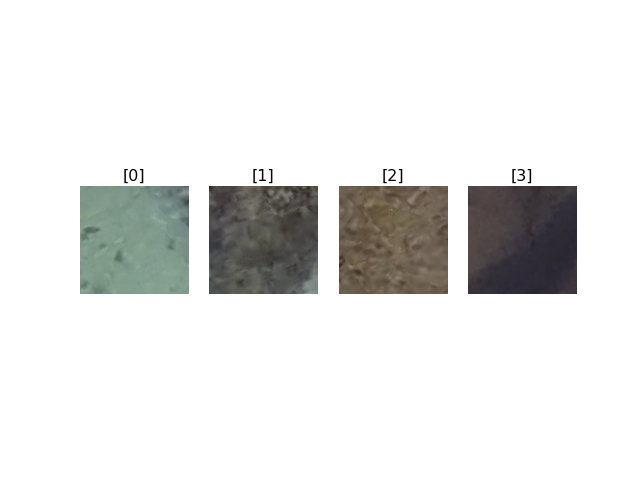

<IPython.core.display.Javascript object>


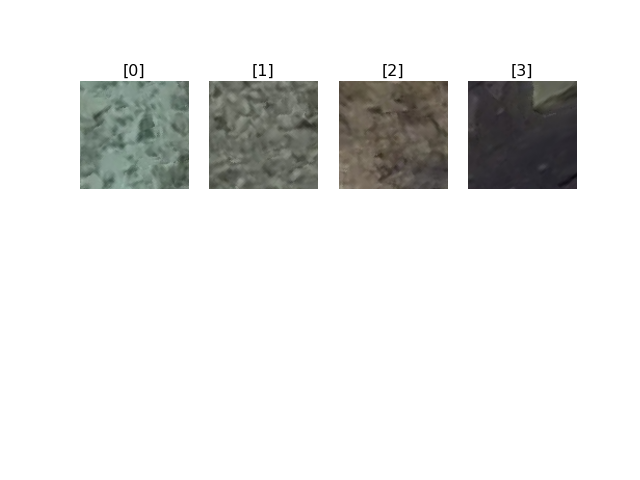

<IPython.core.display.Javascript object>


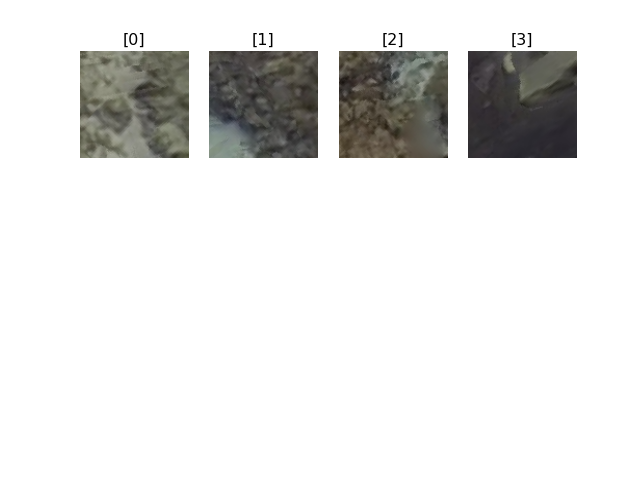

Training dataset dimensions:  (40000, 105, 105, 3) Training labels dimensions:  (40000, 1)
Validation dataset dimensions:  (4000, 105, 105, 3) Validation labels dimensions:  (4000, 1)
Test dataset dimensions:  (4000, 105, 105, 3) Test labels dimensions:  (4000, 1)
Train on 40000 samples, validate on 4000 samples
Epoch 1/10
40000/40000 [==============================] - 13989s - loss: 12.0389 - acc: 0.2528 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 2/10
40000/40000 [==============================] - 13373s - loss: 12.0886 - acc: 0.2500 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 3/10
40000/40000 [==============================] - 12957s - loss: 12.0886 - acc: 0.2500 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 4/10
40000/40000 [==============================] - 13806s - loss: 12.0886 - acc: 0.2500 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 5/10
40000/40000 [==============================] - 13780s - loss: 12.0886 - acc: 0.2500 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 6/10
40000/4000

In [14]:
# define run parameters
#-----------------------
num_classes = 4
#image_size = np.array([25,105])
image_size = 105
#print("image_size",image_size[0])
# run over varying image sizes

# define parameters to save
test_loss = []
test_acc  = []


# prepare data for training
#---------------------------
transect1_path = '../Images/Transect 1 Hi-Res.tiff'
transect1_truth_path = '../Images/Transect 1 Truth data.tif'
Transect1, Transect1_truth = load_data(transect1_path, transect1_truth_path, truth_key=[16,160,198,38])
train_datasets, train_labels, valid_datasets, valid_labels, test_datasets, test_labels = \
generate_training(Transect1, Transect1_truth, image_size = image_size, toremove = 3, figureson=True,
                          N_train=10000, N_valid = 1000, N_test = 1000)

print("Training dataset dimensions: ", train_datasets.shape, "Training labels dimensions: ", train_labels.shape)
print("Validation dataset dimensions: ", valid_datasets.shape, "Validation labels dimensions: ", valid_labels.shape)
print("Test dataset dimensions: ", test_datasets.shape, "Test labels dimensions: ", test_labels.shape)

if train_labels.shape[-1] != num_classes:
    #print("train_labels_shape", train_labels.shape)
    #print("num_classes",num_classes)
    train_labels = keras.utils.to_categorical(train_labels, num_classes)
    valid_labels = keras.utils.to_categorical(valid_labels, num_classes)
    test_labels = keras.utils.to_categorical(test_labels, num_classes)
    #print(train_labels)

# define model
#--------------
model = Sequential()
batch_size = 32
epochs = 10
patch1_size = 5
stride1 = 1
patch2_size = 5
stride2 = 1
depth1 = 64
depth2 = 128
depth3 = 256
depth4 = 64
im_size = image_size

# this is CNN with 2 conv layers and 2 FC layers
    
model.add(Conv2D(depth1, (patch1_size,patch1_size), strides=(stride1,stride1), activation='relu', 
                 kernel_initializer = TruncatedNormal(mean=0,stddev=0.1), input_shape=(im_size,im_size,3)))
model.add(Conv2D(depth2, (patch2_size,patch2_size), strides=(stride2,stride2), activation='relu', 
                 kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))

model.add(Flatten())
model.add(Dense(depth3, activation='relu',
                    kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))
model.add(Dense(depth4, activation='relu', kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))
model.add(Dense(num_classes, activation = 'softmax', kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))

model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
model.fit(train_datasets, train_labels,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(valid_datasets, valid_labels))
score = model.evaluate(test_datasets, test_labels, verbose=0)
    
print('Test loss for image_size %i is %.1f%%'     % (im_size,score[0]))
print('Test loss: ', score[0])
print('Test accuracy for image_size %i is %.2f%%' % (im_size,score[1]))
print('Test accu: ', score[1])
    
# append score results
test_loss.append(np.round(100*(score[0])/100))
test_acc.append(np.round(1000*(score[1])/1000))
    
# save model
#-------------
model_name = 'KerasCNN_image_size_' + str(image_size)
    
# serialize model to JSON
model_json = model.to_json()
with open(model_name + '.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(model_name + '.h5')
print(model_name, " model saved to disk")
    
# print model summary
#---------------------
model.summary()

# print train results
#---------------------
#print('Test loss for image sizes: ', image_size, "is:")
#print('%.2f%%', test_loss)
#print('Test accuracy for image sizes: ', image_size, "is:")
#print('%.2f%%', test_acc)

# Now upload real data (images) and predict with each of the generated models

In [68]:

def load_whole_data(img1, img1_truth, image_size, depth=255, offset=0, lines=None, toremove = False):
    crop_len = int(np.floor(image_size/2))
    
    if lines is None:
        lines = img1.shape[0]-2*crop_len
    
    if offset + lines + 2*crop_len > img1.shape[0]:
        print("Too many lines specified, reverting to maximum possible")
        lines = im1.shape[0] - offset - 2*crop_len
    
    whole_datasets = []
    whole_labels = []
    for i in range(offset+crop_len,lines+offset+crop_len):
        for j in range(crop_len, img1.shape[1]-crop_len):
            whole_datasets.append(img1[i-crop_len:i+crop_len+1, j-crop_len:j+crop_len+1,:])
            whole_labels.append(img1_truth[i,j])
            
    whole_datasets = np.asarray(whole_datasets) 
    whole_labels = np.asarray(whole_labels).reshape((len(whole_labels),1))
    
    if toremove is not None:
        whole_datasets = np.delete(whole_datasets,toremove,-1) # Remove specific last dimension of array
    
    whole_dataset = rescale(whole_datasets,depth)
    return whole_dataset, whole_labels

def classifyback(predictions):
    return np.argmax(predictions,1)

In [76]:
# predict using saved models
#-----------------------------

#model = load_model('firstKerasmodel.h5')
#image_size = (15,25)

#for im in range(len(image_size)):
    
im_size = image_size
    
# load model:
model_name = 'KerasCNN_image_size_' + str(im_size)
# load json and create model
json_file = open(model_name + '.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_name + ".h5")
print("Loaded model from disk")
model = loaded_model
    
# predict image line by line
whole_predict = []
offstart = 0
crop_len = int(np.floor(im_size/2))
num_lines = Transect1_truth.shape[0] - 2*crop_len
for offset in range(offstart,offstart+num_lines):
    if (offset % 1000 == 0):
        print('Now on step %d ', offset)
    temp_dataset, temp_labelset = load_whole_data(Transect1, Transect1_truth, image_size=im_size, offset = offset, lines=1, toremove=3)
        
    temp_predict = model.predict_on_batch(temp_dataset)
        
    whole_predict.append(classifyback(temp_predict))
        

whole_predict = np.asarray(whole_predict)
print(whole_predict.shape)
    
# calculate accuracy
#--------------------

truth_predict = Transect1_truth[crop_len+offstart:crop_len+offstart+num_lines, crop_len:Transect1_truth.shape[1]-crop_len]
    
y_true = truth_predict.ravel()
y_pred = whole_predict.ravel()
    
# overall accuracy
overall_accuracy = 100*accuracy_score(y_true, y_pred)
print('Final Accuracy (overall) for image_size %i is %.1f%%' % (im_size,overall_accuracy))
# weighted accuracy
w = np.ones(y_true.shape[0])
for idx, i in enumerate(np.bincount(y_true)):
    w[y_true == idx] *= (i/float(y_true.shape[0]))
w_accuracy = 100*accuracy_score(y_true, y_pred, sample_weight=w)
print('Final Accuracy (weighted) %.1f%%' % (w_accuracy))
# per class accuracy
num_labels = len(np.unique(truth_predict))
#0  # Sand
#1  # Branching
#2  # Mounding
#3  # Rock
class_labels = ('Sand','Branching','Mounding','Rock')
for i in range(num_labels):
    true = y_true[y_true==i]
    pred = y_pred[y_true==i]
    accuracy = 100*accuracy_score(true, pred)
    print('Accuracy for class %i (%s) is %.1f%%' % (i,class_labels[i], accuracy))
        
# plot prediction
#-----------------
    
plt.figure()
plt.subplot(1,2,1)
plt.imshow(whole_predict)
# plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(truth_predict)
# plt.axis('off')
plt.show()
plt_name = "whole_predict_cnn_image_size_" + str(im_size) + ".png"
plt.savefig(plt_name,bbox_inches = 'tight',dpi=1000)


Loaded model from disk
Now on step %d  0
Now on step %d  100
Now on step %d  200
Now on step %d  300
Now on step %d  400
Now on step %d  500
Now on step %d  600
Now on step %d  700
Now on step %d  800
Now on step %d  900
Now on step %d  1000
Now on step %d  1100
Now on step %d  1200
Now on step %d  1300
Now on step %d  1400
Now on step %d  1500
Now on step %d  1600
Now on step %d  1700
Now on step %d  1800
Now on step %d  1900
Now on step %d  2000
Now on step %d  2100
Now on step %d  2200
Now on step %d  2300
Now on step %d  2400
Now on step %d  2500
Now on step %d  2600
Now on step %d  2700
Now on step %d  2800
Now on step %d  2900
Now on step %d  3000
Now on step %d  3100
Now on step %d  3200
Now on step %d  3300
Now on step %d  3400
Now on step %d  3500
Now on step %d  3600
Now on step %d  3700
Now on step %d  3800
Now on step %d  3900
Now on step %d  4000
Now on step %d  4100
Now on step %d  4200
Now on step %d  4300
Now on step %d  4400
Now on step %d  4500
Now on step %d  4600
No

<IPython.core.display.Javascript object>


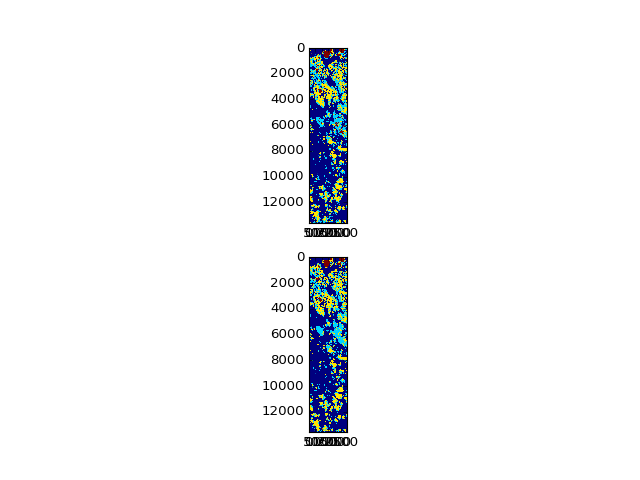

In [50]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(whole_predict)
# plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(truth_predict)
# plt.axis('off')
plt.show()

In [29]:
print(Transect1_truth.shape)

(13598, 3005)
